In [9]:
from scipy import sparse
import numpy as np
import pandas as pd
import mglearn
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

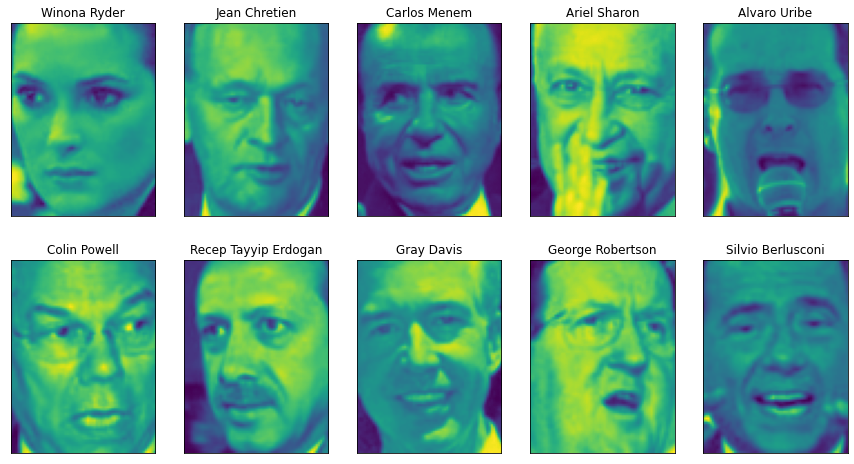

In [10]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8),
                        subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, 
                             axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [11]:
print("форма массива изображений лиц: {}".format(people.images.shape))
print("количество классов: {}".format(len(people.target_names)))

форма массива изображений лиц: (3023, 87, 65)
количество классов: 62


In [12]:
# вычисляем частоту встречаемости каждого ответа
counts = np.bincount(people.target)
# печатаем частоты рядом с ответами
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print('{0:25} {1:3}'.format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

In [13]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# для получения большей стабильности масштабируем шкалу 
# оттенков серого так, чтобы значения были в диапазоне от 0 до 1 
# вместо использования шкалы значений от 0 до 255
X_people = X_people / 255.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# разбиваем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_people, 
        y_people, stratify=y_people, random_state=0)
# строим KNeighborsClassifier с одним соседом
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Правильность на тестовом наборе для 1-nn: {:.2f}".format(
    knn.score(X_test, y_test)))

Правильность на тестовом наборе для 1-nn: 0.23


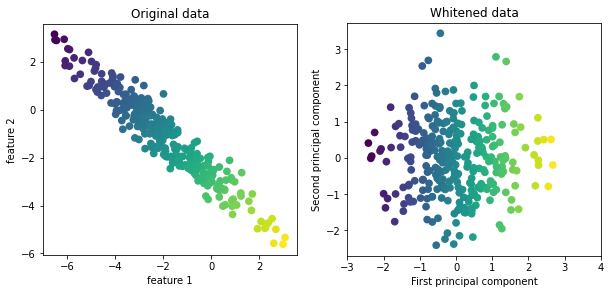

In [15]:
mglearn.plots.plot_pca_whitening()

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("обучающие данные после PCA: {}".format(X_train_pca.shape))

обучающие данные после PCA: (1547, 100)


In [17]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Правильность на тестовом наборе: {:.2f}".format(
    knn.score(X_test_pca, y_test)))

Правильность на тестовом наборе: 0.31


In [18]:
print("форма pca.components_: {}".format(pca.components_.shape))

форма pca.components_: (100, 5655)


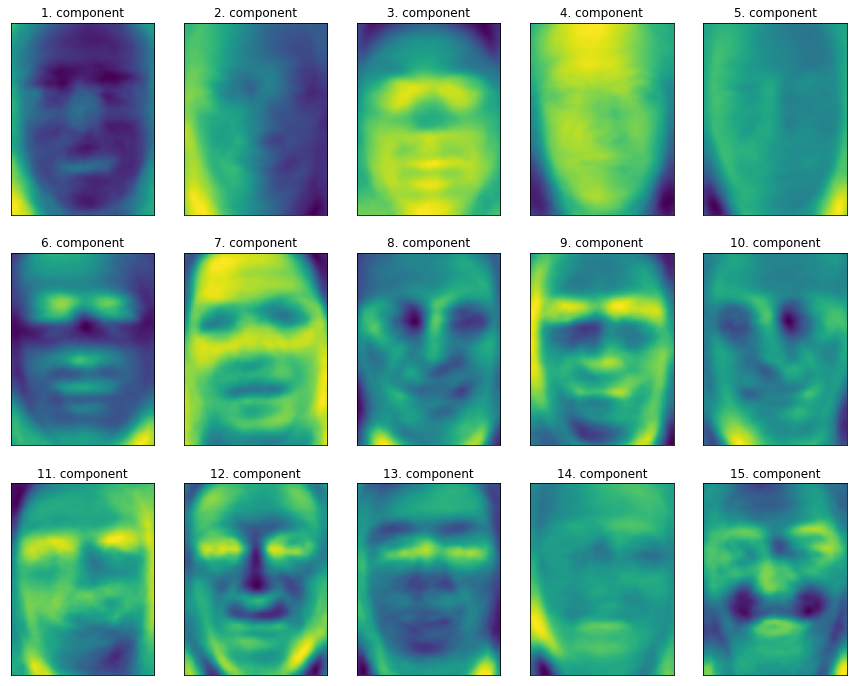

In [19]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                        subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_,
                                       axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title('{}. component'.format((i + 1)))

Text(0, 0.5, 'Вторая главная компонента')

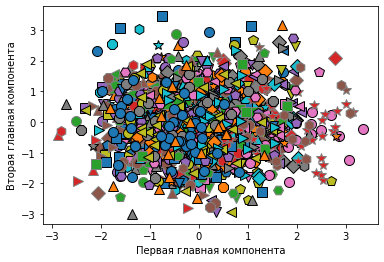

In [20]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                         y_train)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")

/home/miss/kaggle/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/miss/kaggle/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


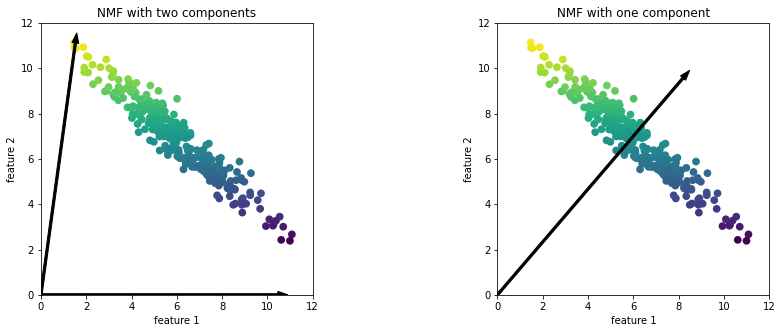

In [21]:
mglearn.plots.plot_nmf_illustration()

/home/miss/kaggle/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


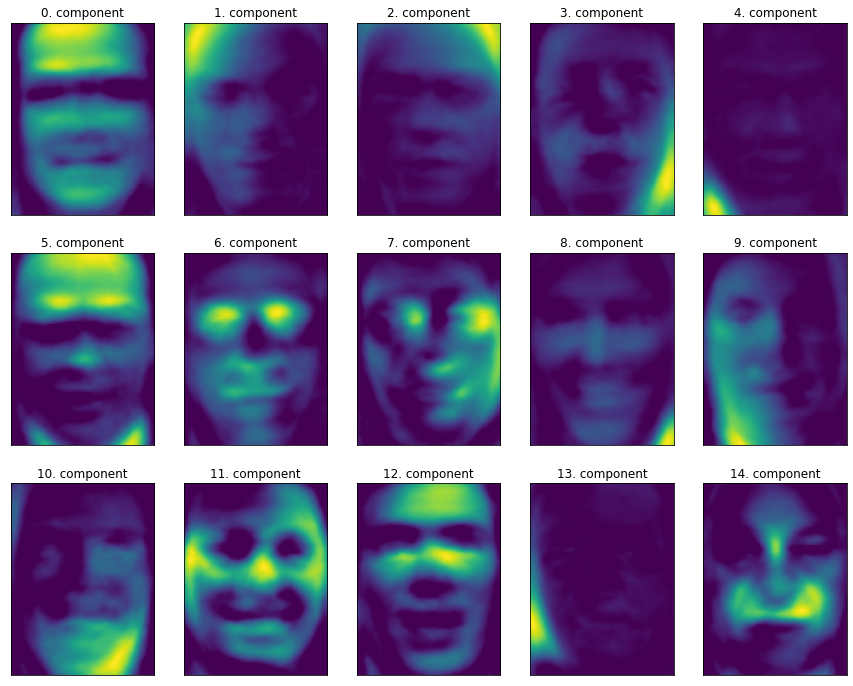

In [24]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                        subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, 
                                       axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title('{}. component'.format(i))

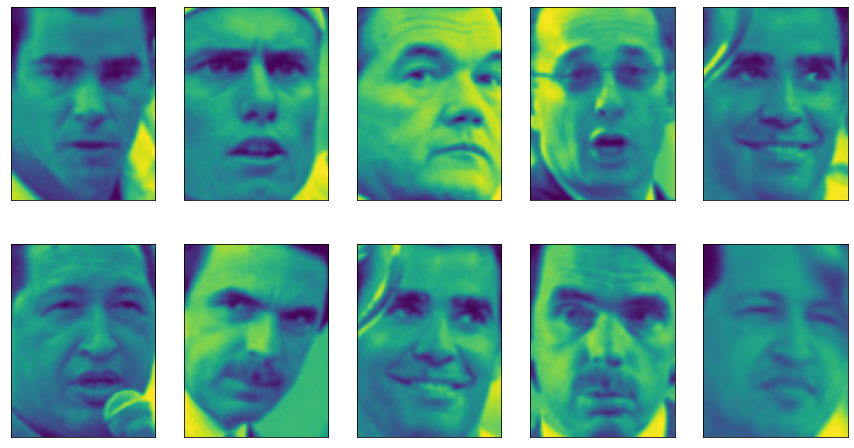

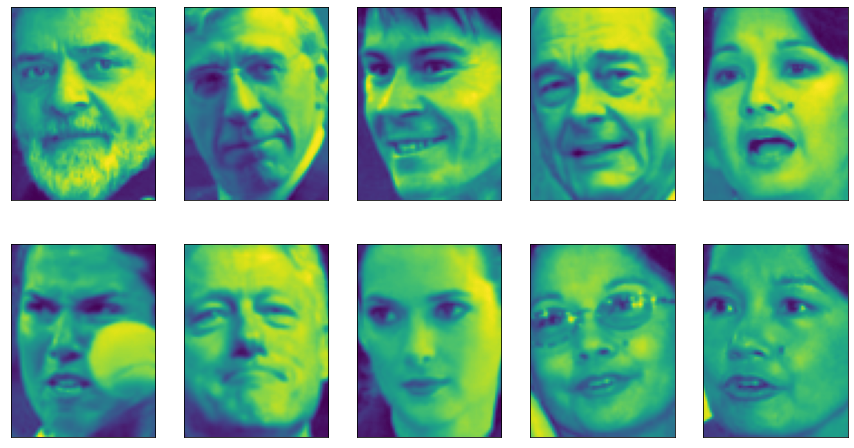

In [26]:
compn = 3
# сортируем по 3-й компоненте, выводим первые 10 изображений
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
compn = 7
# сортируем по 7-й компоненте, выводим первые 10 изображений
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

Text(0, 0.5, 'Сигнал')

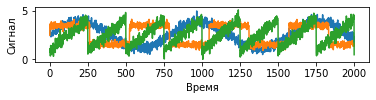

In [27]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel('Время')
plt.ylabel('Сигнал')

In [28]:
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print('Форма измерений: {}'.format(X.shape))

Форма измерений: (2000, 100)


In [30]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print('Форма востановленного сигнала: {}'.format(S_.shape))

pca = PCA(n_components=3)
H = pca.fit_transform(X)

Форма востановленного сигнала: (2000, 3)


/home/miss/kaggle/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


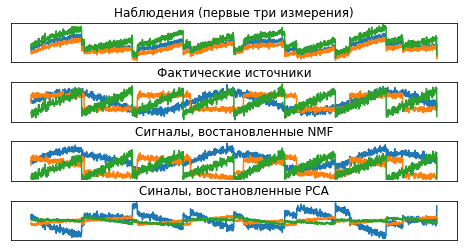

In [31]:
models = [X, S, S_, H]
names = ['Наблюдения (первые три измерения)',
        'Фактические источники',
        'Сигналы, востановленные NMF',
        'Синалы, востановленные PCA']
fig, axes = plt.subplots(4, figsize=(8, 4), 
                         gridspec_kw= {'hspace': .5},
                        subplot_kw = {'xticks': (), 'yticks': ()})
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

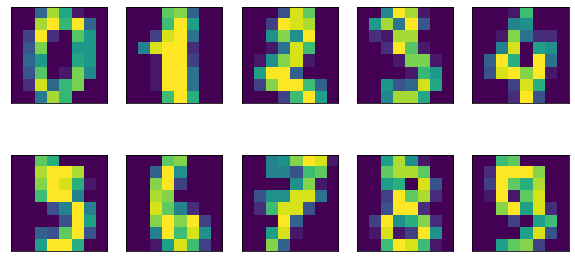

In [33]:
from sklearn.datasets import load_digits

digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                        subplot_kw={'xticks': (), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

Text(0, 0.5, 'Вторая главная компонента')

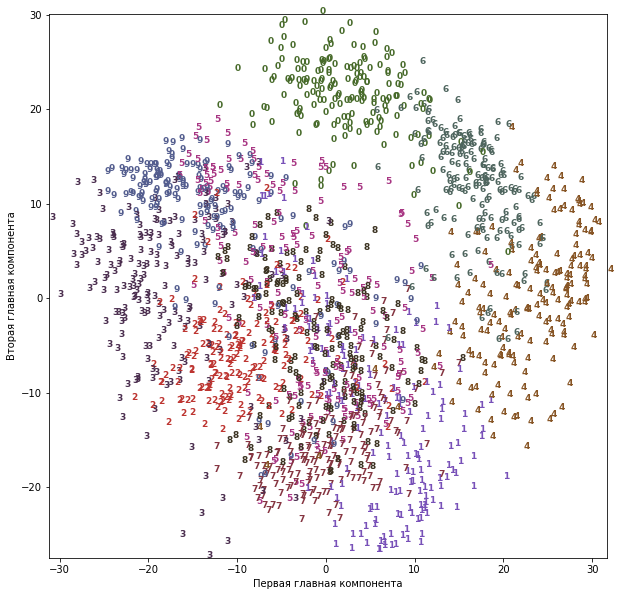

In [35]:
# строим модель PCA
pca = PCA(n_components=2)
pca.fit(digits.data)
# преобразуем данные рукописных цифр к первым двум компонентам
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
"#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # строим график, где цифры представлены символом вместо точек
    plt.text(digits_pca[i, 0], digits_pca[i, 1], 
            str(digits.target[i]), color=colors[digits.target[i]],
            fontdict={'weight': 'bold', 'size': 9})
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')

Text(0.5, 0, 't-SNE признак 1')

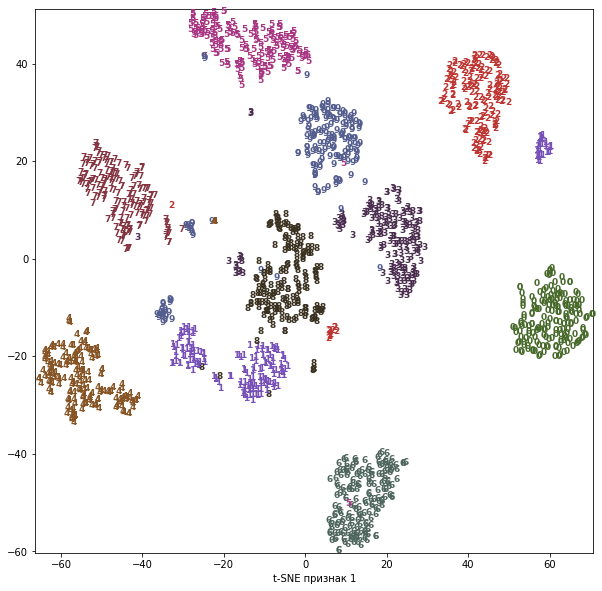

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
# используем метод fit_transform вместо fit, так как класс TSNE
# не использует метод transform
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
    color = colors[digits.target[i]],
    fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE признак 0")
plt.xlabel("t-SNE признак 1")

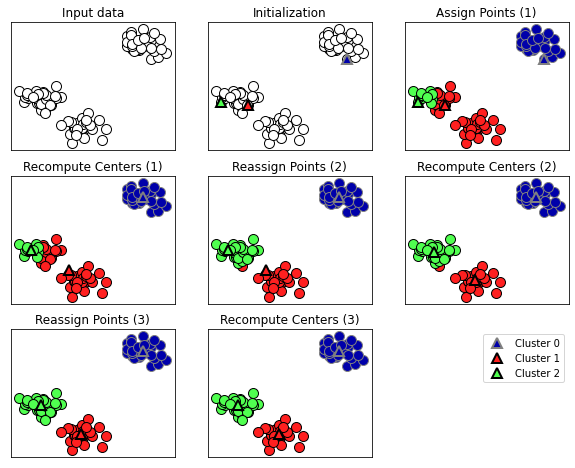

In [39]:
mglearn.plots.plot_kmeans_algorithm()

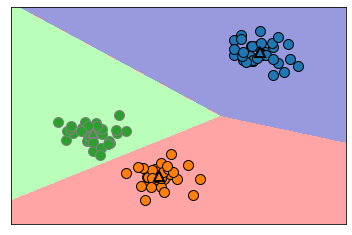

In [40]:
mglearn.plots.plot_kmeans_boundaries()

In [41]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# генерируем синтетические двумерные данные
X, y = make_blobs(random_state=1)

# строим модель кластеризации
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

print("Принадлежность к кластерам:\n{}".format(kmeans.labels_))

Принадлежность к кластерам:
[0 1 1 1 2 2 2 1 0 0 1 1 2 0 2 2 2 0 1 1 2 1 2 0 1 2 2 0 0 2 0 0 2 0 1 2 1
 1 1 2 2 1 0 1 1 2 0 0 0 0 1 2 2 2 0 2 1 1 0 0 1 2 2 1 1 2 0 2 0 1 1 1 2 0
 0 1 2 2 0 1 0 1 1 2 0 0 0 0 1 0 2 0 0 1 1 2 2 0 2 0]


In [43]:
print(kmeans.predict(X))

[0 1 1 1 2 2 2 1 0 0 1 1 2 0 2 2 2 0 1 1 2 1 2 0 1 2 2 0 0 2 0 0 2 0 1 2 1
 1 1 2 2 1 0 1 1 2 0 0 0 0 1 2 2 2 0 2 1 1 0 0 1 2 2 1 1 2 0 2 0 1 1 1 2 0
 0 1 2 2 0 1 0 1 1 2 0 0 0 0 1 0 2 0 0 1 1 2 2 0 2 0]


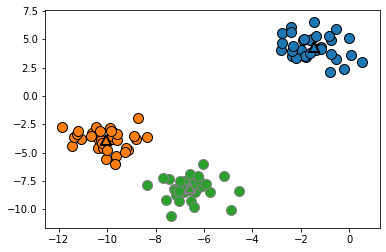

In [44]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_,
                        markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0],
                        kmeans.cluster_centers_[:, 1], [0, 1, 2],
                        markers='^', markeredgewidth=2)

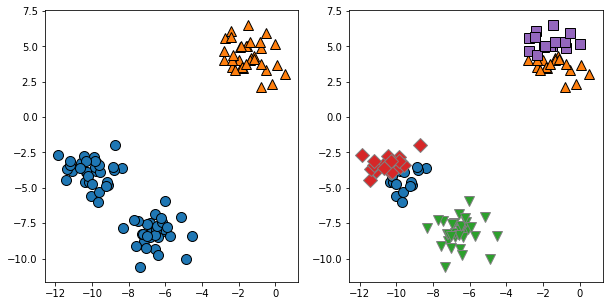

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# использование двух центров кластеров:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assigments = kmeans.labels_

mglearn.discrete_scatter(X[:, 0], X[:, 1], assigments, ax=axes[0])

# использование 5 центров кластеров
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
assigments = kmeans.labels_

mglearn.discrete_scatter(X[:, 0], X[:, 1], assigments, ax=axes[1])

Text(0, 0.5, 'Признак 1')

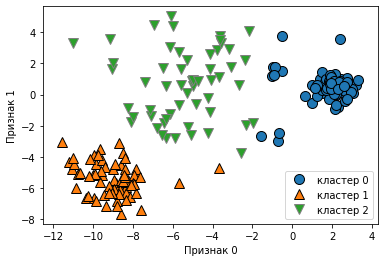

In [49]:
X_varied, y_varied = make_blobs(n_samples=200,
cluster_std=[1.0, 2.5, 0.5],
random_state=170)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X_varied)
mglearn.discrete_scatter(X_varied[:, 0], X_varied[:, 1], y_pred)
plt.legend(["кластер 0", "кластер 1", "кластер 2"], loc='best')
plt.xlabel("Признак 0")
plt.ylabel("Признак 1")

Text(0, 0.5, 'Признак 1')

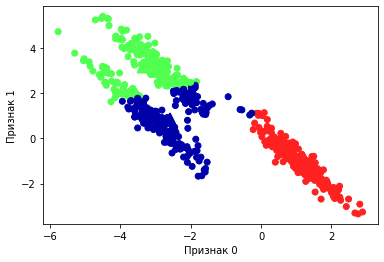

In [50]:
# генерируем случайным образом данные для кластеризации
X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)
# преобразуем данные так, чтобы они были вытянуты по диагонали
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)
# группируем данные в три кластера
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)
# строим график принадлежности к кластерам и центров кластеров
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=mglearn.cm3)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
marker='^', c=[0, 1, 2], s=100, linewidth=2, cmap=mglearn.cm3)
plt.xlabel("Признак 0")
plt.ylabel("Признак 1")

Text(0, 0.5, 'Признак 1')

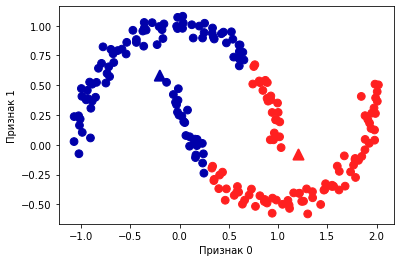

In [51]:
# генерируем синтетические данные two_moons (на этот раз с меньшим количеством шума)
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
# группируем данные в два кластера
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)
# строим график принадлежности к кластерам и центров кластеров
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=mglearn.cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
marker='^', c=[mglearn.cm2(0), mglearn.cm2(1)], s=100, linewidth=2)
plt.xlabel("Признак 0")
plt.ylabel("Признак 1")

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
X_people, y_people, stratify=y_people, random_state=0)

nmf = NMF(n_components=100, random_state=0)
nmf.fit(X_train)

pca = PCA(n_components=100, random_state=0)
pca.fit(X_train)

kmeans = KMeans(n_clusters=100, random_state=0)
kmeans.fit(X_train)

X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kmeans = kmeans.cluster_centers_[kmeans.predict(X_test)]
X_reconstructed_nmf = np.dot(nmf.transform(X_test), nmf.components_)

/home/miss/kaggle/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Text(0, 0.5, 'nmf')

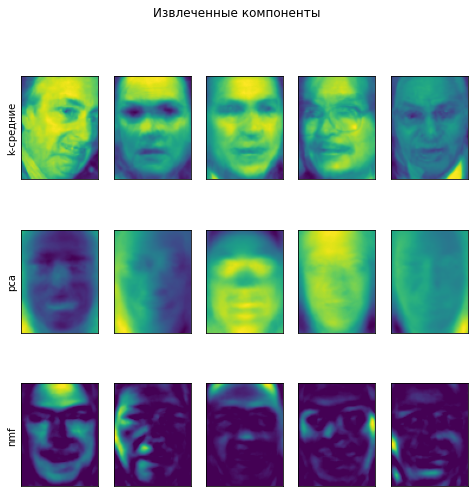

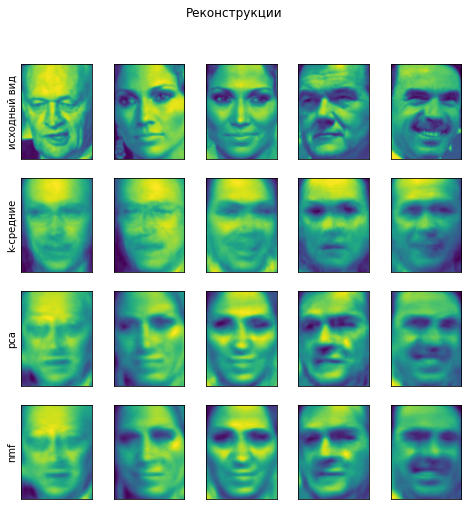

In [53]:
fig, axes = plt.subplots(3, 5, figsize=(8, 8),
subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Извлеченные компоненты")
for ax, comp_kmeans, comp_pca, comp_nmf in zip(
axes.T, kmeans.cluster_centers_, pca.components_, nmf.components_):
    ax[0].imshow(comp_kmeans.reshape(image_shape))
    ax[1].imshow(comp_pca.reshape(image_shape), cmap='viridis')
    ax[2].imshow(comp_nmf.reshape(image_shape))
    
axes[0, 0].set_ylabel("k-средние")
axes[1, 0].set_ylabel("pca")
axes[2, 0].set_ylabel("nmf")

fig, axes = plt.subplots(4, 5, subplot_kw={'xticks': (), 'yticks': ()},
figsize=(8, 8))
fig.suptitle("Реконструкции")
for ax, orig, rec_kmeans, rec_pca, rec_nmf in zip(
axes.T, X_test, X_reconstructed_kmeans, X_reconstructed_pca,
X_reconstructed_nmf):
    ax[0].imshow(orig.reshape(image_shape))
    ax[1].imshow(rec_kmeans.reshape(image_shape))
    ax[2].imshow(rec_pca.reshape(image_shape))
    ax[3].imshow(rec_nmf.reshape(image_shape))
axes[0,0].set_ylabel("исходный вид")
axes[1,0].set_ylabel("k-средние")
axes[2,0].set_ylabel("pca")
axes[3,0].set_ylabel("nmf")

Принадлежность к кластерам:
[4 7 6 9 7 7 4 1 4 1 8 3 7 1 0 4 2 3 2 0 5 1 2 1 8 6 7 5 6 2 4 8 1 6 4 5 3
 4 0 6 3 8 2 6 7 8 4 0 6 1 0 3 5 9 1 4 2 1 2 8 3 9 7 4 1 9 8 7 8 9 3 9 3 6
 1 9 6 4 2 3 5 8 3 5 6 8 4 8 3 5 2 4 5 0 5 7 7 3 9 6 1 5 8 4 9 6 9 8 7 2 0
 8 8 9 4 1 2 5 3 4 4 0 6 8 6 0 4 6 1 5 4 0 9 3 1 7 1 9 5 4 6 6 2 8 8 4 6 1
 2 6 3 7 4 2 3 8 1 3 2 2 6 1 2 7 3 7 2 3 7 1 2 9 0 0 6 1 5 0 0 2 7 0 5 7 5
 2 8 3 9 0 9 2 4 4 6 0 5 6 2 7]


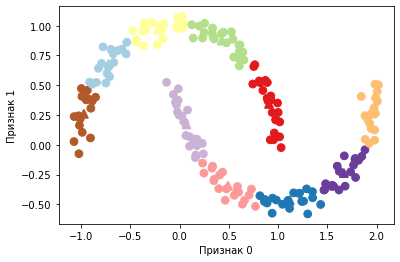

In [54]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=60, cmap='Paired')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=60,
marker='^', c=range(kmeans.n_clusters), linewidth=2, cmap='Paired')
plt.xlabel("Признак 0")
plt.ylabel("Признак 1")
print("Принадлежность к кластерам:\n{}".format(y_pred))

In [55]:
distance_features = kmeans.transform(X)
print("Форма характеристик-расстояний: {}".format(
    distance_features.shape))
print("Характеристики-расстояния:\n{}".format(distance_features))

Форма характеристик-расстояний: (200, 10)
Характеристики-расстояния:
[[1.54731274 1.03376805 0.52485524 ... 1.14060718 1.12484411 1.80791793]
 [2.56907679 0.50806038 1.72923085 ... 0.149581   2.27569325 2.66814112]
 [0.80949799 1.35912551 0.7503402  ... 1.76451208 0.71910707 0.95077955]
 ...
 [1.12985081 1.04864197 0.91717872 ... 1.50934512 1.04915948 1.17816482]
 [0.90881164 1.77871545 0.33200664 ... 1.98349977 0.34346911 1.32756232]
 [2.51141196 0.55940949 1.62142259 ... 0.04819401 2.189235   2.63792601]]


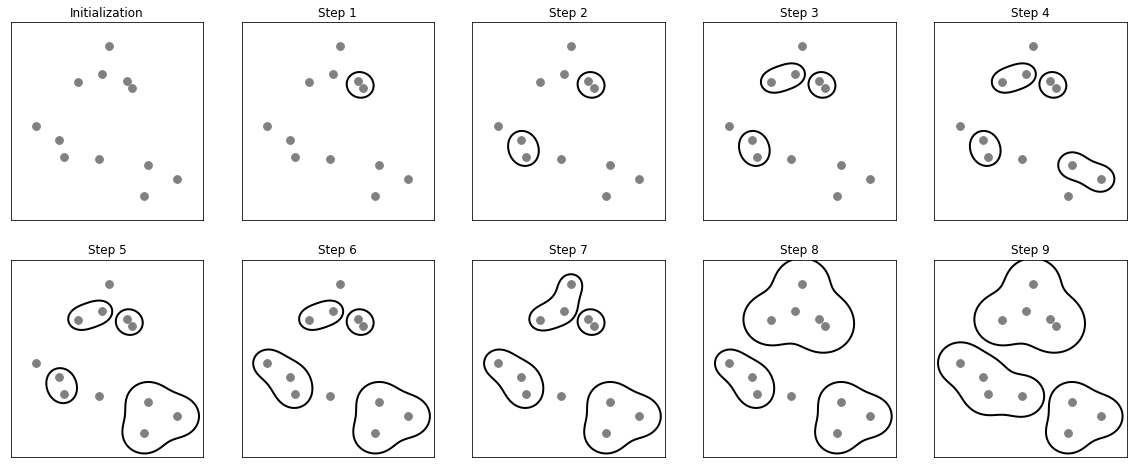

In [56]:
mglearn.plots.plot_agglomerative_algorithm()

Text(0, 0.5, 'Признак 1')

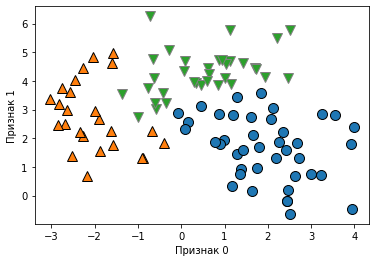

In [57]:
from sklearn.cluster import AgglomerativeClustering

X, y = make_blobs(random_state=0)
agg = AgglomerativeClustering(n_clusters=3)
assigment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:, 0], X[:, 1], assigment)
plt.xlabel('Признак 0')
plt.ylabel('Признак 1')